In [1]:
#from legend_plot_style import LEGENDPlotStyle as lps

In [2]:
#lps.use('legend_talks')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import json
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata/')

In [5]:
run_dict = {'p03':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p04':{'r000':{},'r001':{},'r002':{},'r003':{}},
            'p06':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p07':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}#,'r007':{}}}
            #'p08':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}

In [6]:
data_path = '/Users/romoluque_c/LEGEND/Energy_scale_group/Partitioning/data_example/'
test_file = data_path + 'l200-p03-r000-cal-20230311T235840Z-par_pht.json'

In [7]:
def cal_energy(e_uncal, cal_pars):
    if len(cal_pars.keys())==2:
        #print('lin')
        return cal_pars['a'] * e_uncal + cal_pars['b'], 'lin'
    elif len(cal_pars.keys())==3:
        #print('quad')
        return cal_pars['a'] * e_uncal **2 + cal_pars['b'] * e_uncal + cal_pars['c'], 'quad'

In [8]:
sel_channel = 'ch1104000'

Qbb_fwhms_in_keV, Qbb_fwhms_err_in_keV = [], []
eres_lin_pars0  , eres_lin_pars0_err   = [], []
eres_lin_pars1  , eres_lin_pars1_err   = [], []
gains           = []
mus_peaks       , mus_err_peaks        = {}, {}
fwhms_peaks     , fwhms_err_peaks      = {}, {}
ecals_peaks     = {}

for period in run_dict.keys():
    for run in run_dict[period].keys():
        all_files = os.listdir(data_path)
        filename  = data_path + [f for f in all_files if f.startswith(f'l200-{period}-{run}')][0]
        with open (filename, 'r') as filehandler:
            results   = json.load(filehandler)
            res_chn   = results[sel_channel]['results']['ecal']

            ## Parameters for calibration
            cal_parameters = results[sel_channel]['pars']['operations']['cuspEmax_ctc_cal']['parameters']
            
            ## Parameters for resolution curve
            eres_lin_pars = res_chn['cuspEmax_ctc_cal']['eres_linear']
            Qbb_fwhms_in_keV    .append(eres_lin_pars['Qbb_fwhm_in_keV'])
            Qbb_fwhms_err_in_keV.append(eres_lin_pars['Qbb_fwhm_err_in_keV'])
            eres_lin_pars0      .append(eres_lin_pars['parameters']   ['a'])
            eres_lin_pars0_err  .append(eres_lin_pars['uncertainties']['a'])
            eres_lin_pars1      .append(eres_lin_pars['parameters']   ['b'])
            eres_lin_pars1_err  .append(eres_lin_pars['uncertainties']['b'])
            gains               .append(cal_parameters['b'])
                        
            fitted_peaks   = res_chn['cuspEmax_ctc_cal']['fitted_peaks']
            peak_fits_pars = res_chn['cuspEmax_ctc_cal']['pk_fits']
            
            mus_peaks      [f'{period}-{run}'] = [peak_fits_pars[f'{peak}']['parameters_in_ADC']   ['mu'] for peak in fitted_peaks]
            mus_err_peaks  [f'{period}-{run}'] = [peak_fits_pars[f'{peak}']['uncertainties_in_ADC']['mu'] for peak in fitted_peaks]
            fwhms_peaks    [f'{period}-{run}'] = [peak_fits_pars[f'{peak}']['fwhm_in_keV']         [0]    for peak in fitted_peaks]
            fwhms_err_peaks[f'{period}-{run}'] = [peak_fits_pars[f'{peak}']['fwhm_in_keV']         [1]    for peak in fitted_peaks]
            ecals_peaks    [f'{period}-{run}'] = [cal_energy(peak_fits_pars[f'{peak}']['parameters_in_ADC']['mu'], cal_parameters)[0] for i, peak in enumerate(fitted_peaks)]
            
peak_data = {'mus_peaks': {}, 'mus_err_peaks': {}, 'fwhms_peaks': {}, 'fwhms_err_peaks': {}, 'ecals_peaks': {}}
for val, par in zip(peak_data.values(), [mus_peaks, mus_err_peaks, fwhms_peaks, fwhms_err_peaks, ecals_peaks]):
    for i, peak in enumerate(fitted_peaks):
        val[peak] = [val[i] for val in par.values()]

In [9]:
labels = [f'{key}-{run}' for key in run_dict.keys() for run in run_dict[key].keys()]

### Position of the different peaks:

In [10]:
fitted_peaks

[583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5]

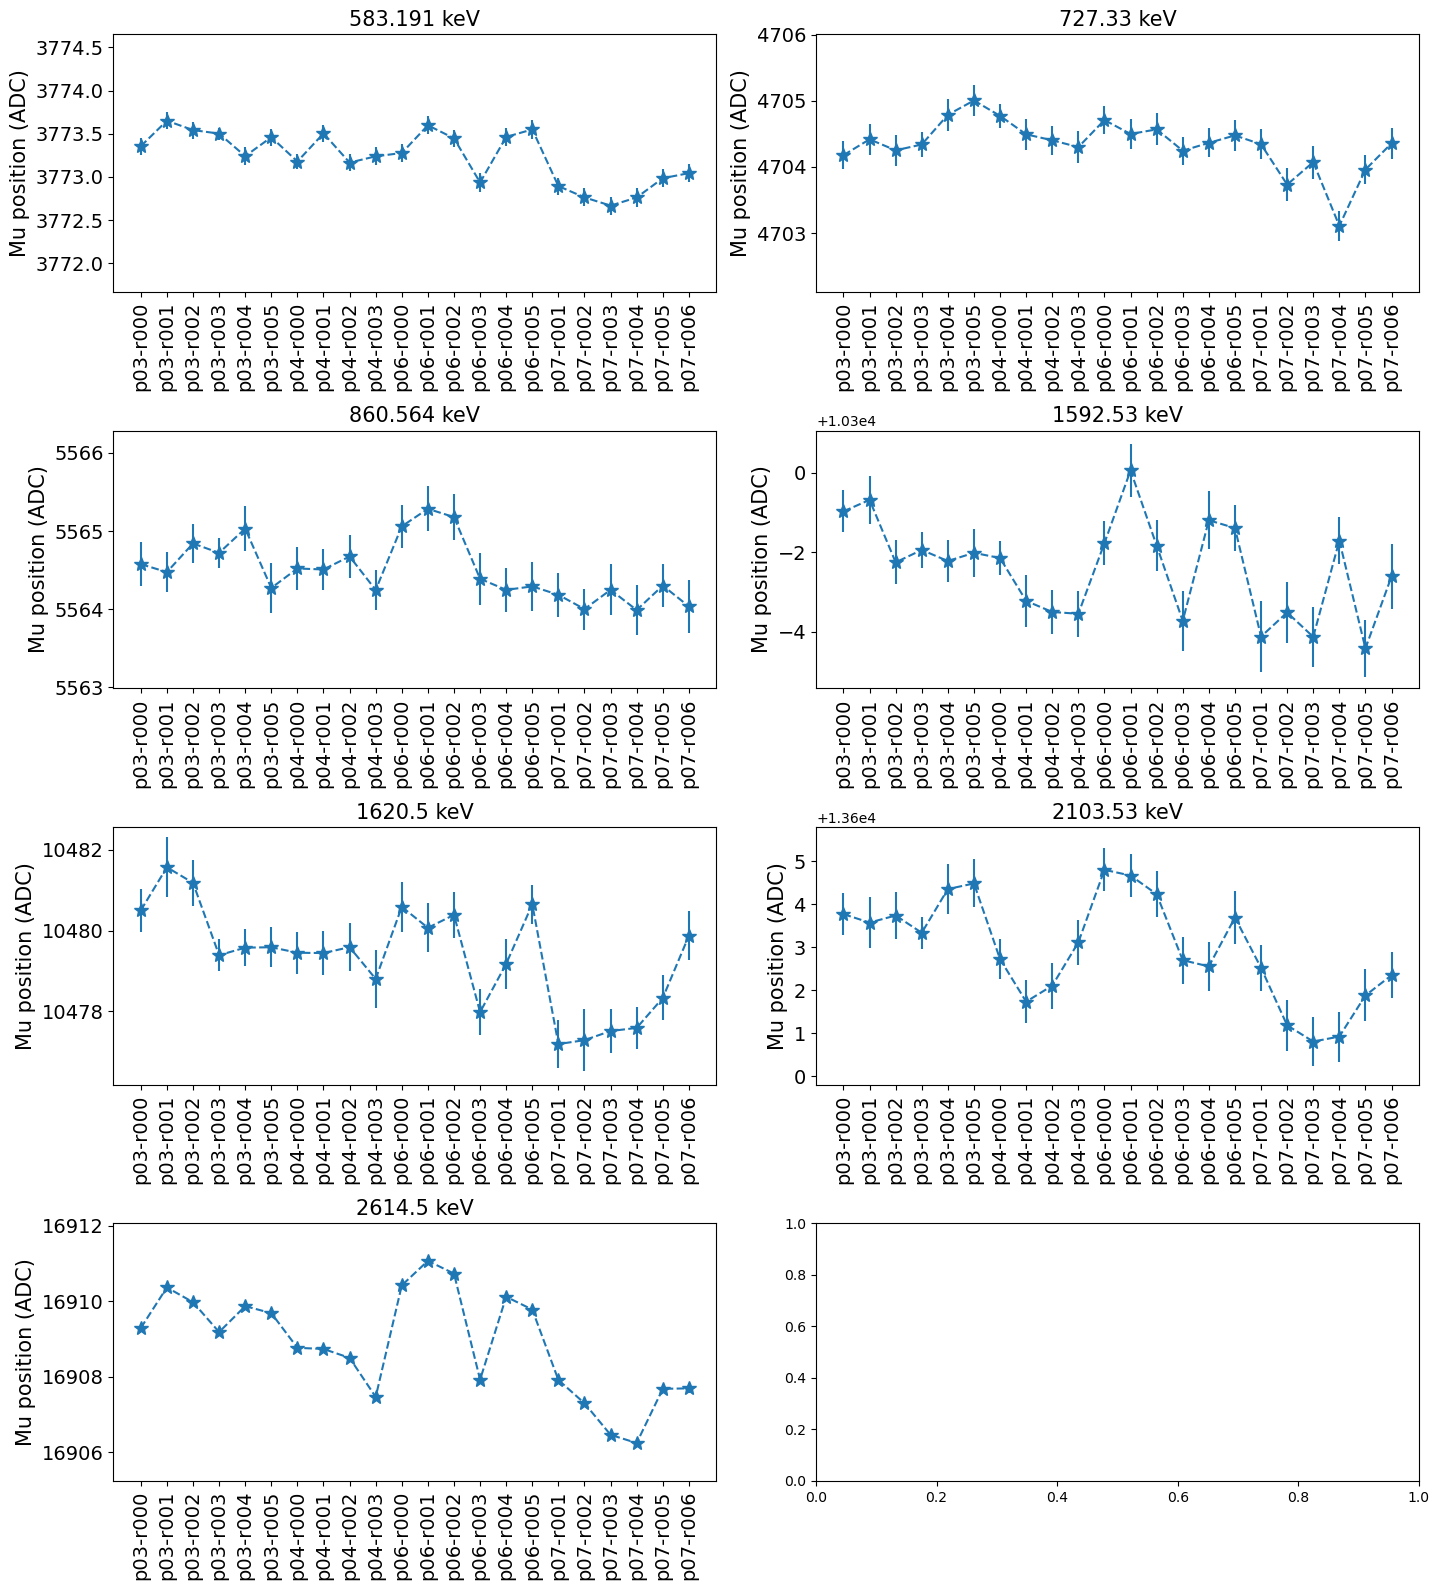

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak) in enumerate(zip(axs.flatten(), fitted_peaks)):
    ax.errorbar(labels, peak_data['mus_peaks']    [peak],
                   yerr=peak_data['mus_err_peaks'][peak], marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(min(peak_data['mus_peaks'][peak])-1, max(peak_data['mus_peaks'][peak])+1)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('Mu position (ADC)', fontsize=15)
plt.tight_layout()
plt.show()
#for i, (ax, par, err, ylim, ylab, col) in enumerate(zip(axs.flatten(), params, errs, ylims, ylabels, colors)):

### FWHM for all peaks:

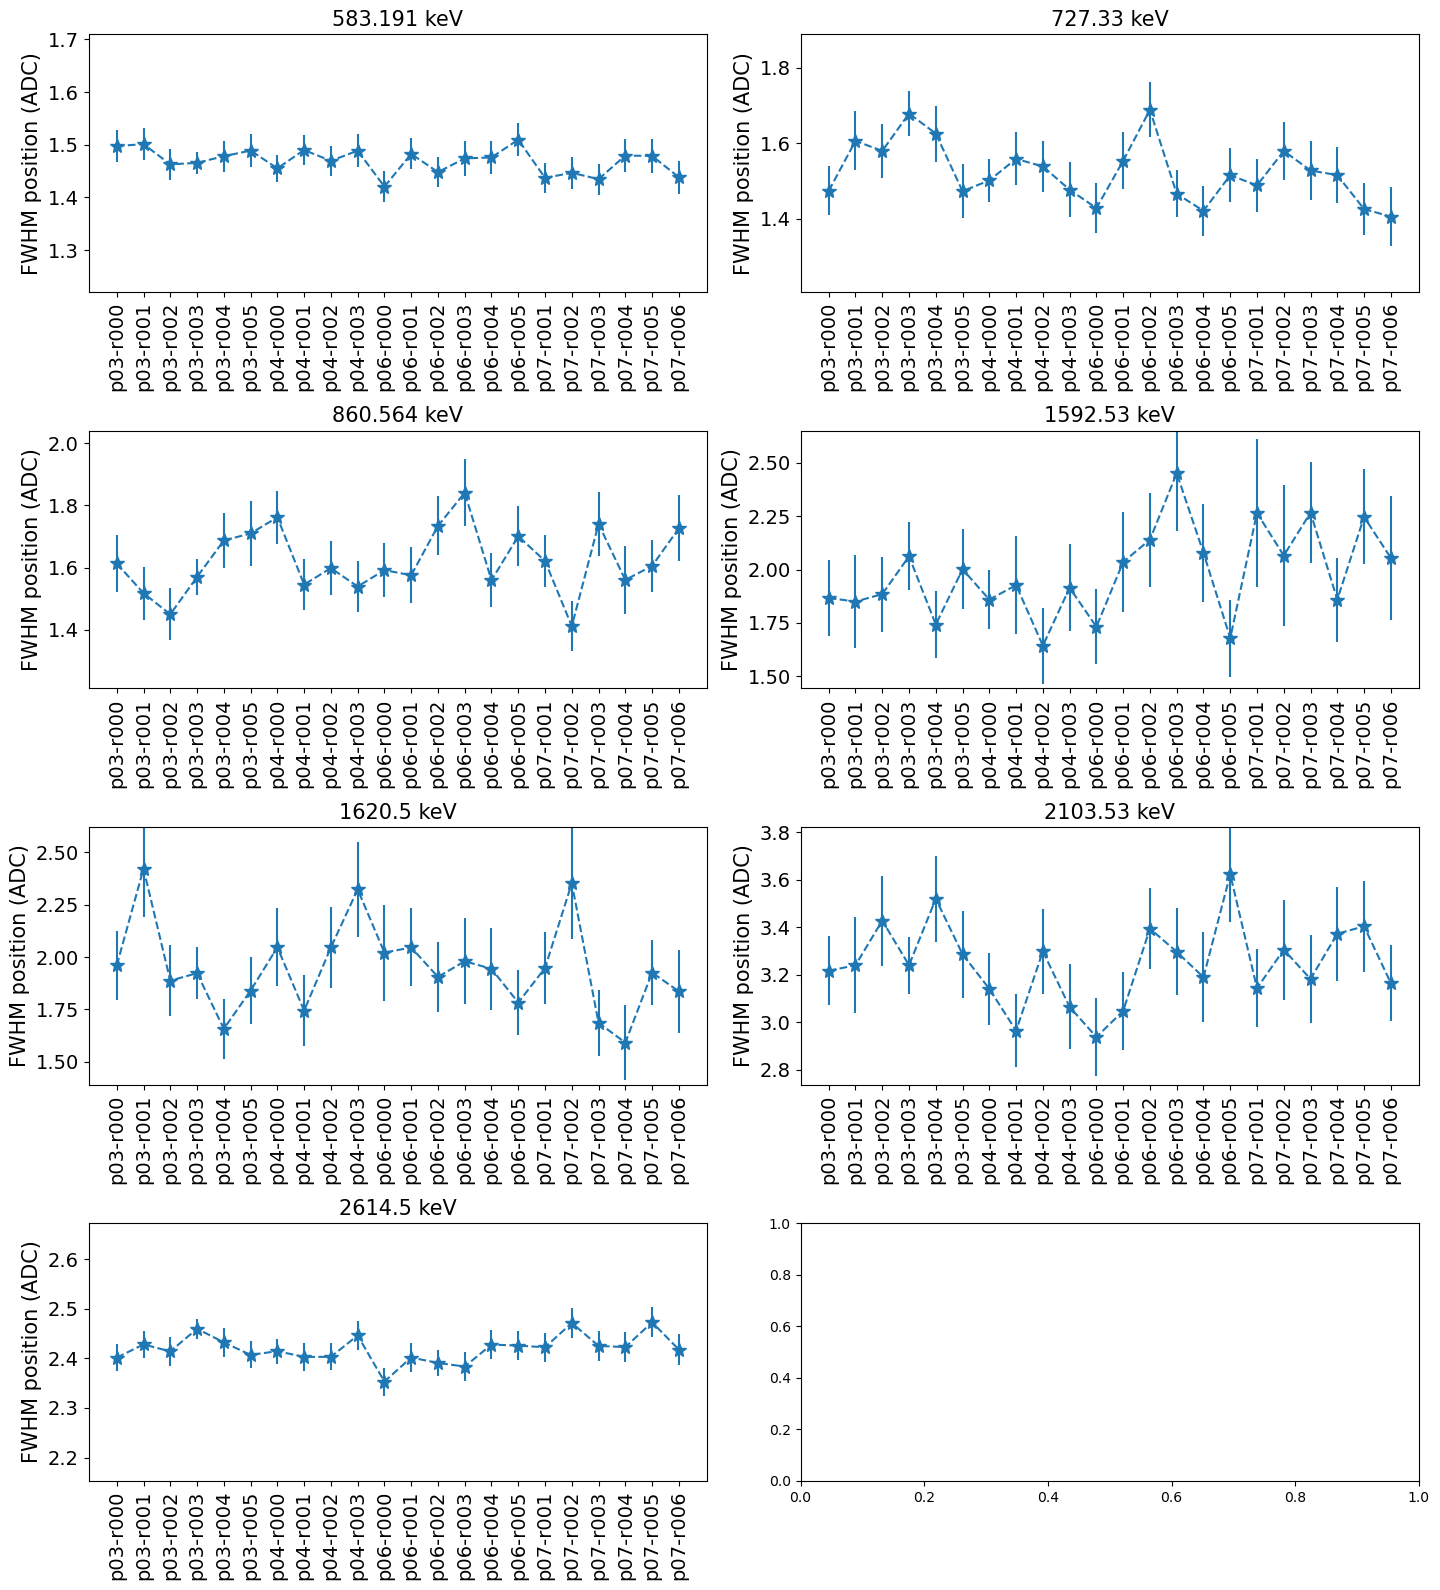

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak) in enumerate(zip(axs.flatten(), fitted_peaks)):
    ax.errorbar(labels, peak_data['fwhms_peaks']    [peak],
                   yerr=peak_data['fwhms_err_peaks'][peak], marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(min(peak_data['fwhms_peaks'][peak])-0.2, max(peak_data['fwhms_peaks'][peak])+0.2)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('FWHM position (ADC)', fontsize=15)
plt.tight_layout()
plt.show()

### Residuals

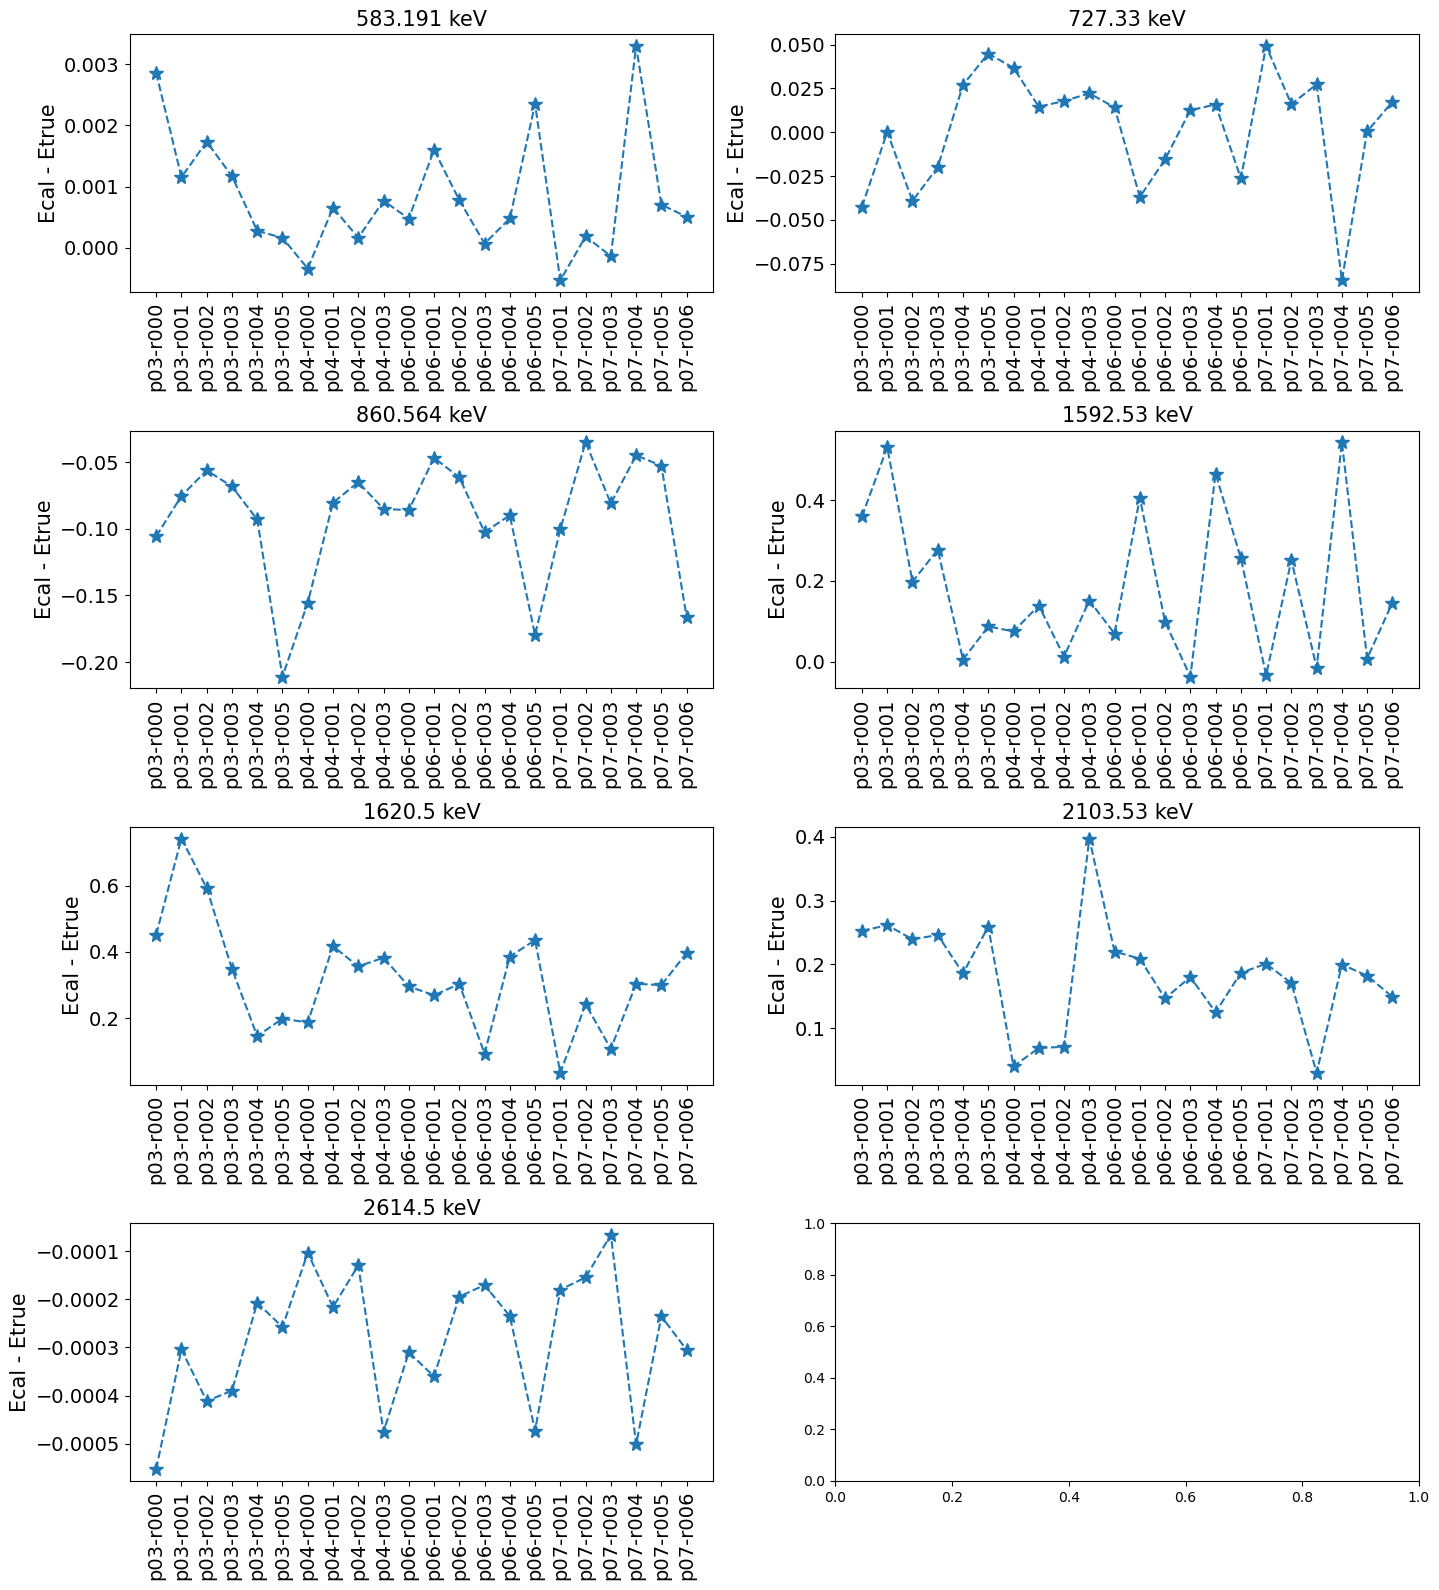

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak) in enumerate(zip(axs.flatten(), fitted_peaks)):
    ax.errorbar(labels, np.array(peak_data['ecals_peaks'][peak]) - peak, marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    #ax.set_ylim(min(peak_data['ecals_peaks'][peak])-0.01, max(peak_data['ecals_peaks'][peak])+0.01)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('Ecal - Etrue', fontsize=15)
plt.tight_layout()
plt.show()

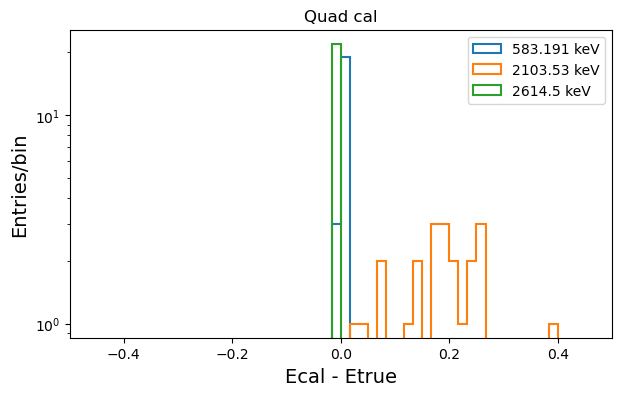

In [14]:
fig = plt.figure(figsize=(7, 4))
for i, peak in enumerate(fitted_peaks):
    if i in [0, 5, 6]:
        plt.hist(np.array(peak_data['ecals_peaks'][peak]) - peak, bins=60, range=(-0.5, 0.5), histtype='step', linewidth=1.5, label=f'{peak} keV')
plt.xlabel('Ecal - Etrue', fontsize=14)
plt.ylabel('Entries/bin',  fontsize=14)
plt.title('Quad cal')
plt.xlim(-0.5, 0.5)
plt.legend()
plt.yscale('log')
plt.show()

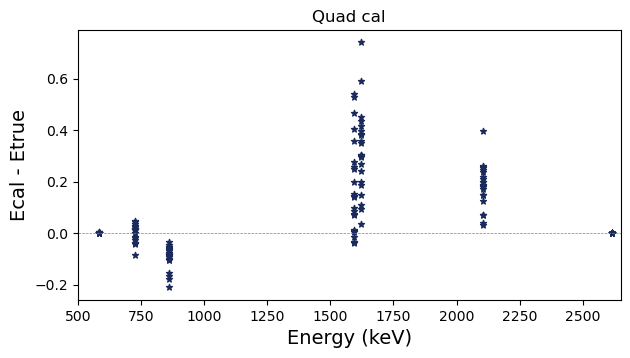

In [15]:
fig = plt.figure(figsize=(7, 3.5))
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
for i, peak in enumerate(fitted_peaks):
    plt.scatter(np.full(len(peak_data['ecals_peaks'][peak]), peak), np.array(peak_data['ecals_peaks'][peak]) - peak, marker='*', s=20, color='#1A2A5B')
plt.xlabel('Energy (keV)', fontsize=14)
plt.ylabel('Ecal - Etrue', fontsize=14)
plt.title('Quad cal')
plt.xlim(500, 2650)
#plt.yscale('log')
plt.show()

In [16]:
fitted_peaks

[583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5]

### Parameters to plot

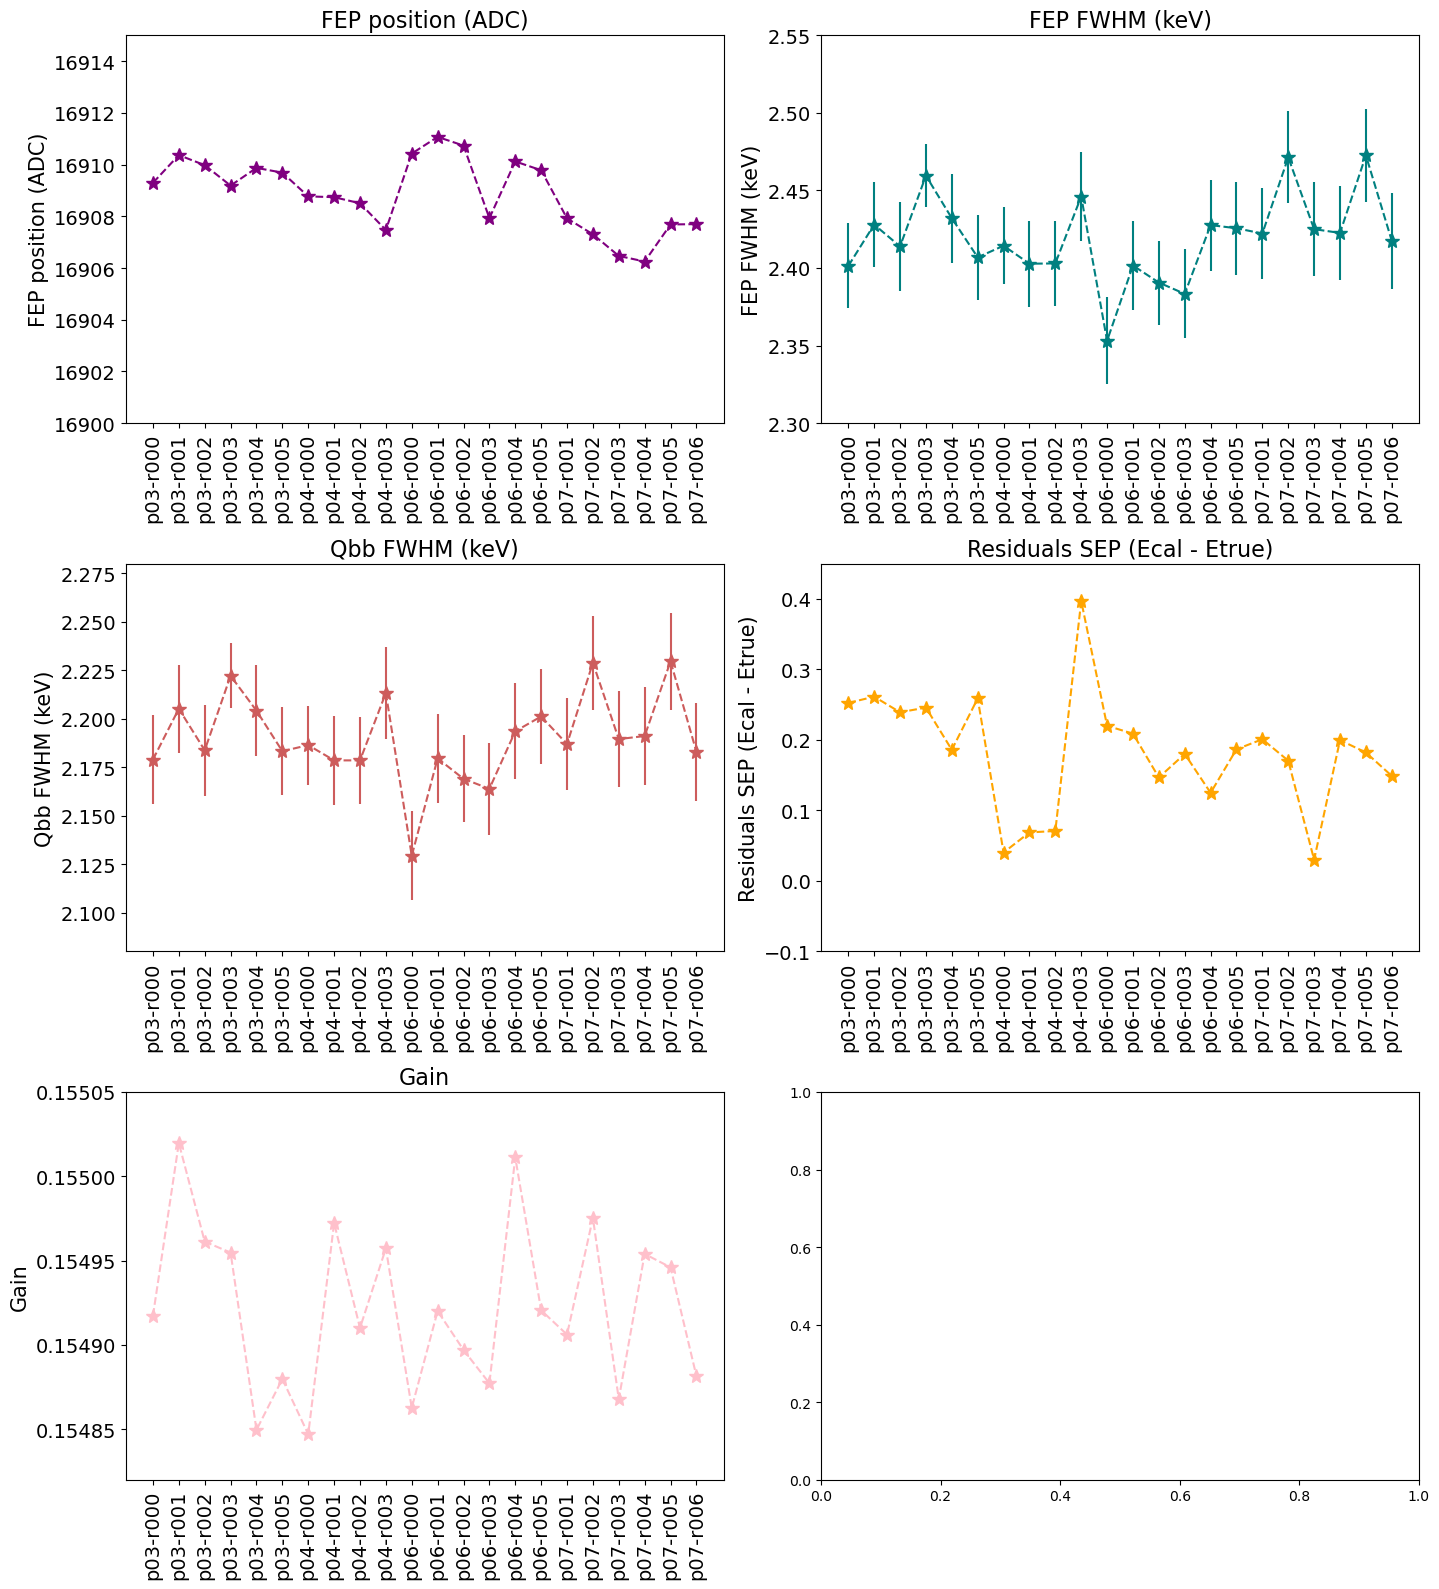

In [17]:
params   = [peak_data['mus_peaks']    [2614.5], peak_data['fwhms_peaks']    [2614.5], Qbb_fwhms_in_keV,     np.array(peak_data['ecals_peaks'][2103.53]) - 2103.53, gains]
errs     = [peak_data['mus_err_peaks'][2614.5], peak_data['fwhms_err_peaks'][2614.5], Qbb_fwhms_err_in_keV, np.full(22, 0.0001),                                   np.full(len(gains), 0)]

ylims    = [(16900, 16915), (2.30, 2.55), (2.08, 2.28), (-0.1, 0.45), (0.154820, 0.155050)]
ylabels  = ['FEP position (ADC)', 'FEP FWHM (keV)', 'Qbb FWHM (keV)', 'Residuals SEP (Ecal - Etrue)', 'Gain']
colors   = ['purple', 'teal', 'indianred', 'orange', 'pink']

fig, axs = plt.subplots(3, 2, figsize=(14.5, 16))
for i, (ax, par, err, ylim, ylab, col) in enumerate(zip(axs.flatten(), params, errs, ylims, ylabels, colors)):
    ax.errorbar(labels, par, yerr=err, marker='*', linestyle='--', markersize=10, color=col)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(ylim)
    ax.set_title(ylab,  fontsize=16)
    ax.set_ylabel(ylab, fontsize=15)
plt.tight_layout()
plt.show()

In [18]:
### LEGEND STYLE

### fig, axs = lps.subplots(2, 2, figsize=(14.5, 12))
### params   = [mus_FEP,     fwhms_FEP,     Qbb_fwhms_in_keV,     gains    ]
### errs     = [mus_err_FEP, fwhms_err_FEP, Qbb_fwhms_err_in_keV, gains_err]
### ylims    = [(16900, 16915), (2.30, 2.51), (2.08, 2.28), (0.0015, 0.0021)]
### ylabels  = ['FEP position (ADC)', 'FEP FWHM (keV)', 'Qbb FWHM (keV)', 'Gain from linear cal (ADC)']
### colors   = ['purple', 'legend_darkblue', 'legend_orange', 'legend_violet']
### 
### for i, (ax, par, err, ylim, ylab, col) in enumerate(zip(axs.flatten(), params, errs, ylims, ylabels, colors)):
###     ax.errorbar(labels, par, yerr=err, marker='*', linestyle='--', markersize=10, color=lps.colors[col])
###     ax.tick_params(axis='x', labelsize=18, rotation=90)
###     ax.tick_params(axis='y', labelsize=18)
###     ax.set_ylim(ylim)
###     ax.set_ylabel(ylab, fontsize=18)
### plt.tight_layout()
### plt.show()

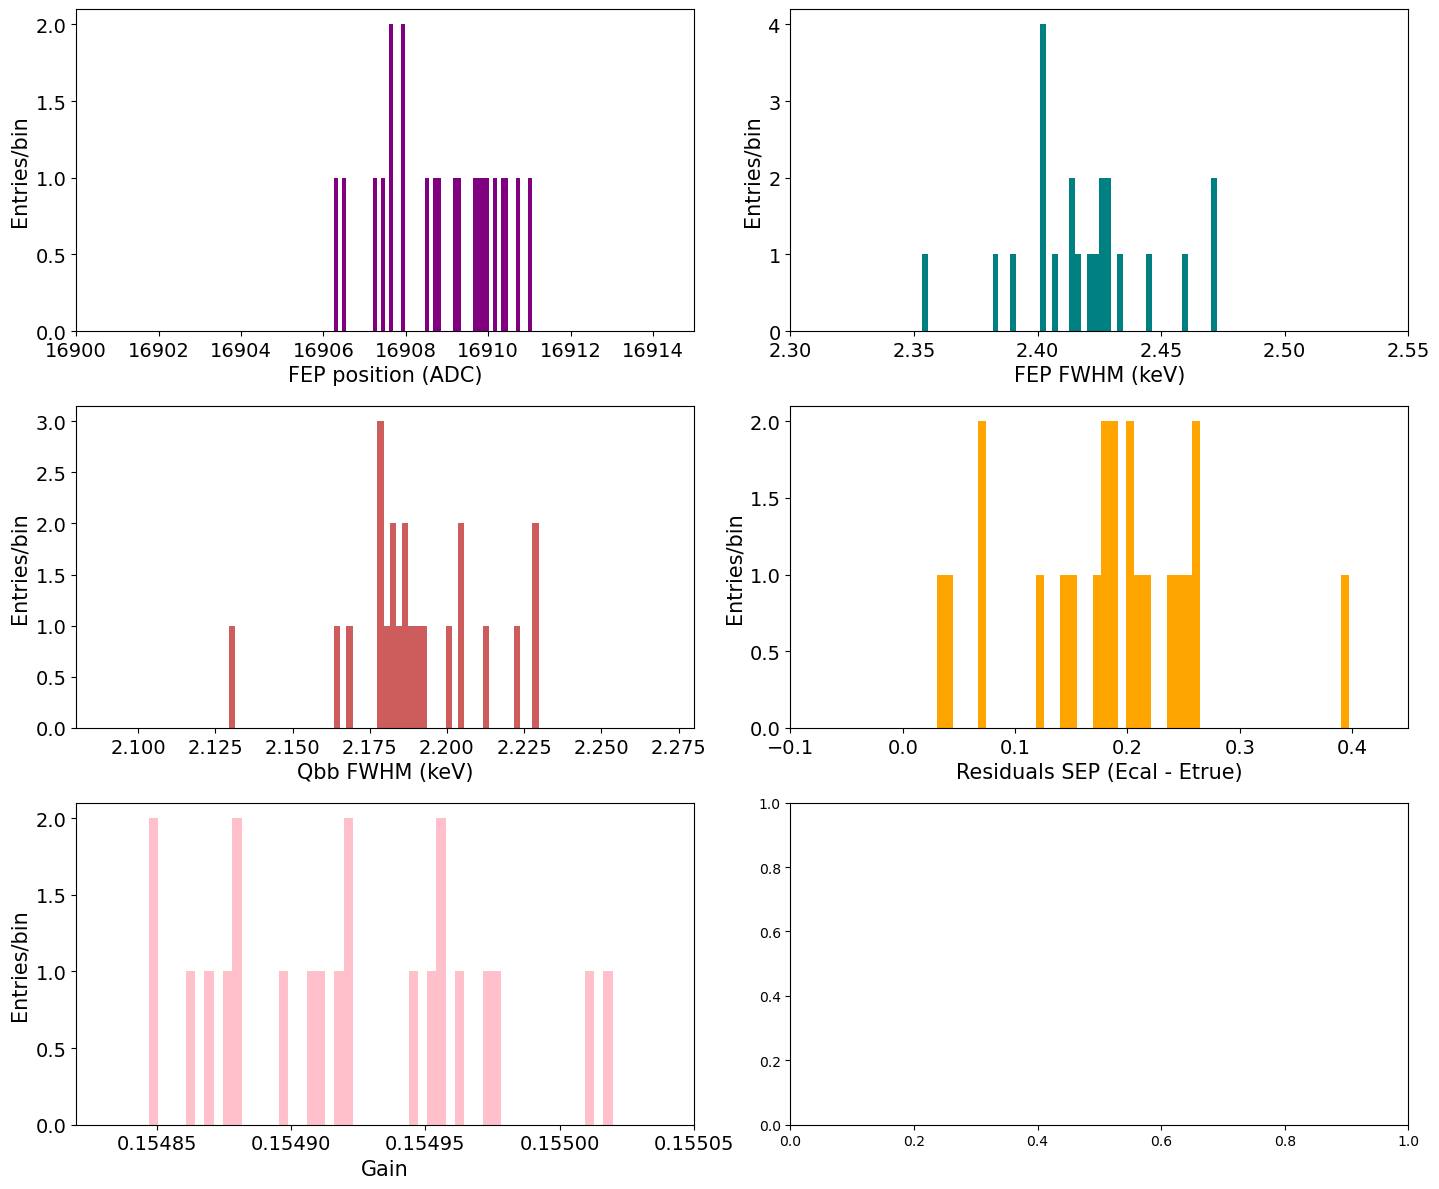

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(14.5, 12))
for i, (ax, par, err, ylim, ylab, col) in enumerate(zip(axs.flatten(), params, errs, ylims, ylabels, colors)):
    ax.hist(par, bins=50, color=col)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim(ylim)
    ax.set_xlabel(ylab, fontsize=15)
    ax.set_ylabel('Entries/bin', fontsize=15)
plt.tight_layout()
plt.show()